# Report

Let's set the random seeds for reproducibility.

In [143]:
import numpy as np
import random
import torch

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


## Data Preprocessing

We will start by loading the data for the Apple stock and inspecting their first few rows.

In [3]:
import yfinance as yf
import pandas as pd

# Download Apple stock data
stock_prices = yf.download('AAPL', 
                   start='2015-01-01', 
                   end='2024-01-31')

# Display the first few rows
print("First few rows of Apple stock data:")
stock_prices.head()

[*********************100%***********************]  1 of 1 completed

First few rows of Apple stock data:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02 00:00:00+00:00,24.373955,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08 00:00:00+00:00,24.944683,27.972500,28.037500,27.174999,27.307501,237458000


Let's examine the path of the stock's closing price over time.

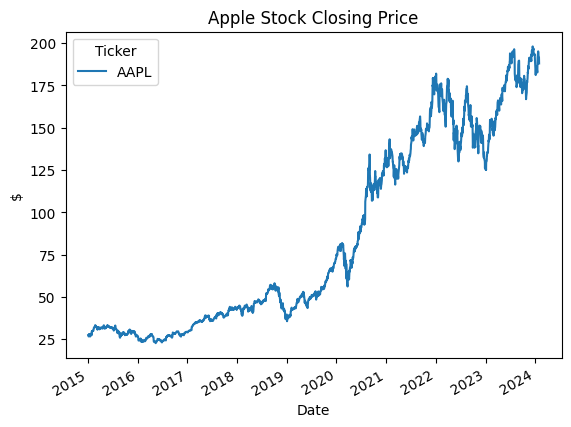

In [4]:
import matplotlib.pyplot as plt

stock_prices['Close'].plot()
plt.title('Apple Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()



The stock price has a clear upward (multiplicative) trend over time as expected from such a tech company. There is a dip in early 2019 and 2020 probably due to the COVID-19 pandemic, which is followed by a signigicant growh rate. The volatility seems to be inceasing as the price is increasing.

Let's check for any missing values in the dataset.


In [5]:
# Check for missing values in the dataset
stock_prices.isnull().sum()

Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64

There are no missing values in the dataset.

We proceed with the calculation of the daily returns. We expect to have only one missing value in the daily returns due to the nature of the calculation.

We then define the extreme events, which will act as our target variable.

In [6]:
# Calculate the daily returns
stock_prices['Daily_Returns'] = stock_prices['Adj Close'].pct_change() * 100

# Remove the first row as it is a NaN value
stock_prices = stock_prices.dropna()
stock_prices.head()


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400,0.009429
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600,1.402214
2015-01-08 00:00:00+00:00,24.944683,27.972500,28.037500,27.174999,27.307501,237458000,3.842223
2015-01-09 00:00:00+00:00,24.971434,28.002501,28.312500,27.552500,28.167500,214798000,0.107240


In [7]:
# Create the Extreme_Event column
stock_prices['Extreme_Event'] = (abs(stock_prices['Daily_Returns']) > 2).astype(int)
stock_prices.head()


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151,1
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400,0.009429,0
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600,1.402214,0
2015-01-08 00:00:00+00:00,24.944683,27.972500,28.037500,27.174999,27.307501,237458000,3.842223,1
2015-01-09 00:00:00+00:00,24.971434,28.002501,28.312500,27.552500,28.167500,214798000,0.107240,0


We expect that the dataset will be imbalanced. Let's verify that.

In [8]:
# Count the number of extreme events
extreme_events = stock_prices[stock_prices['Extreme_Event'] == 1]
print(f"Number of extreme events: {len(extreme_events)}")

# Print the percentage of extreme events and no extreme events in the dataset
print(f"Percentage of extreme events: {len(extreme_events) / len(stock_prices) * 100:.2f}%")
print(f"Percentage of no extreme events: {(len(stock_prices) - len(extreme_events)) / len(stock_prices) * 100:.2f}%")



Number of extreme events: 460
Percentage of extreme events: 20.15%
Percentage of no extreme events: 79.85%


**The dataset is moderately imbalanced with approximately 20% of the data being extreme events. This is a challenge that we will have to address in the modelling phase.**

Our choices for doing so are limited, since we are dealing with a time-series dataset and we need to preserve the temporal nature of the data, which excludes the use of resampling techniques.

For the random forest model, we will scale the loss function using the class weights.

Next, we shift the target variable `Extreme_Event` by one day so that the model is trained to predict if an extreme event occurs **tomorrow** based on today's data.

In [9]:
# Shift the Extreme_Event column by one day
stock_prices['Extreme_Event'] = stock_prices['Extreme_Event'].shift(-1)

# Remove the last row as it is a NaN value
stock_prices = stock_prices.dropna()
stock_prices['Extreme_Event'] = stock_prices['Extreme_Event'].astype(int)
stock_prices.head()

Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687304,26.562500,27.162500,26.352501,27.072500,257142000,-2.817151,0
2015-01-06 00:00:00+00:00,23.689537,26.565001,26.857500,26.157499,26.635000,263188400,0.009429,0
2015-01-07 00:00:00+00:00,24.021715,26.937500,27.049999,26.674999,26.799999,160423600,1.402214,1
2015-01-08 00:00:00+00:00,24.944683,27.972500,28.037500,27.174999,27.307501,237458000,3.842223,0
2015-01-09 00:00:00+00:00,24.971434,28.002501,28.312500,27.552500,28.167500,214798000,0.107240,1


We continue by splitting the data into training, validation and test sets.


In [10]:
# Extract features and labels
features = stock_prices[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Returns']]
labels = stock_prices['Extreme_Event'].astype(int)  # Target variable

# Define train/val/test split ratios
train_ratio = 0.7
val_ratio = 0.85

# Split into train, validation and test sets
train_size = int(train_ratio * len(stock_prices))
val_size = int(val_ratio * len(stock_prices))

X_train = features.iloc[:train_size]
y_train = labels.iloc[:train_size]

X_val = features.iloc[train_size:val_size]
y_val = labels.iloc[train_size:val_size]

X_test = features.iloc[val_size:]
y_test = labels.iloc[val_size:]

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")

Training features shape: (1597, 6), labels shape: (1597,)
Validation features shape: (342, 6), labels shape: (342,)
Test features shape: (343, 6), labels shape: (343,)


Let's check the distribution of labels in the training, validation and test sets. We want to avoid underestimating the performance of the model on unseen data, due to total lack of positive examples.

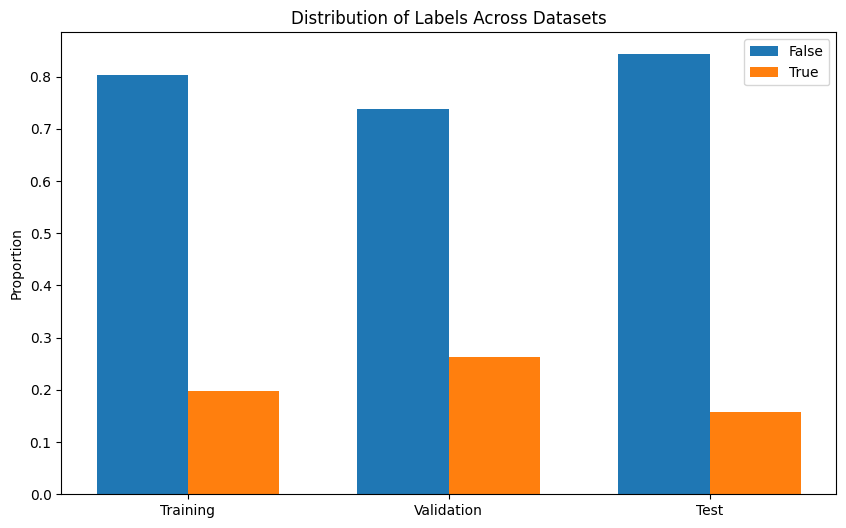

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate distributions
train_dist = y_train.value_counts() / len(y_train)
val_dist = y_val.value_counts() / len(y_val)
test_dist = y_test.value_counts() / len(y_test)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(3)
width = 0.35

# Group bars by False/True
false_vals = [train_dist[0], val_dist[0], test_dist[0]]
true_vals = [train_dist[1], val_dist[1], test_dist[1]]

ax.bar(x - width/2, false_vals, width, label='False')
ax.bar(x + width/2, true_vals, width, label='True')

ax.set_xticks(x)
ax.set_xticklabels(['Training', 'Validation', 'Test'])
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Labels Across Datasets')
ax.legend()

plt.show()


The distribution of labels is similar across the datasets, so we can procced with fitting the models.

As a final step of preprocessing, we will transform the data into a more appropriate format for supervised learning. Specifically, for each day, we will create a sequence of historical features by going back 10 days. Hence, since  the dataset has 6 features, we will end up with 60 features for each day. The corresponding label will be 1 if an extreme event occurs tomorrow and 0 otherwise.

In [12]:
from src.data_preprocessing import StockDataPreprocessor

X_train, y_train = StockDataPreprocessor.time_series_to_supervised(
        X_train, y_train, lookback=10
    )
X_val, y_val = StockDataPreprocessor.time_series_to_supervised(X_val, y_val, lookback=10)
X_test, y_test = StockDataPreprocessor.time_series_to_supervised(X_test, y_test, lookback=10)

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")


Training features shape: (1587, 60), labels shape: (1587,)
Validation features shape: (332, 60), labels shape: (332,)
Test features shape: (333, 60), labels shape: (333,)


Note: All the above steps are implemented in the `src/data_preprocessing.py` file.

Let's examine the first few rows of the training set. For each feature, we will have 10 days of history, amounting to 60 featurs in total.

In [13]:
print(f'Shape of the training set: {X_train.shape}')
X_train.head()


Shape of the training set: (1587, 60)


,Open(t-10),High(t-10),Low(t-10),Close(t-10),Volume(t-10),Daily_Returns(t-10),Open(t-9),High(t-9),Low(t-9),Close(t-9),...,Low(t-2),Close(t-2),Volume(t-2),Daily_Returns(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Daily_Returns(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-20 00:00:00+00:00,27.072500,27.162500,26.352501,26.562500,257142000.0,-2.817190,26.635000,26.857500,26.157499,26.565001,...,26.665001,26.705000,240056000.0,-2.714028,26.757500,26.895000,26.299999,26.497499,314053200.0,-0.777023
2015-01-21 00:00:00+00:00,26.635000,26.857500,26.157499,26.565001,263188400.0,0.009429,26.799999,27.049999,26.674999,26.937500,...,26.299999,26.497499,314053200.0,-0.777023,26.959999,27.242500,26.625000,27.180000,199599600.0,2.575719
2015-01-22 00:00:00+00:00,26.799999,27.049999,26.674999,26.937500,160423600.0,1.402182,27.307501,28.037500,27.174999,27.972500,...,26.625000,27.180000,199599600.0,2.575719,27.237499,27.764999,27.067499,27.387501,194303600.0,0.763421
2015-01-23 00:00:00+00:00,27.307501,28.037500,27.174999,27.972500,237458000.0,3.842256,28.167500,28.312500,27.552500,28.002501,...,27.067499,27.387501,194303600.0,0.763421,27.565001,28.117500,27.430000,28.100000,215185600.0,2.601555
2015-01-26 00:00:00+00:00,28.167500,28.312500,27.552500,28.002501,214798000.0,0.107247,28.150000,28.157499,27.200001,27.312500,...,27.430000,28.100000,215185600.0,2.601555,28.075001,28.437500,27.882500,28.245001,185859200.0,0.516007


# Random Forest Model

Now we will proceed with fitting the random forest model. Since we are using a tree-based model, we will not normalize the data.

In order to tune the hyperparameters of the random forest model, we will use the `hyperopt` library. It uses a Bayesian optimization approach to find the best hyperparameters, called `Tree of Parzen Estimators` (TPE).  This method models the likelihood of the objective function, given the data and a choice of hyperparameters, using kernel density estimation.

The choice of metric for the optimization is nuanced when dealing with imbalanced datasets and one should consider what is the cost of the false negatives and false positives. In our case, a false positive would mean that we falsely predict an extreme event for the next day, which could lead to a loss of capital and trust in the model. On the other hand, a false negative would mean that we falsely predict no extreme event for the next day, which could lead to a loss of potential profits. 

Precision is preffered when false positives are more costly and recall is preffered when false negatives are more costly. Assuming that we are not higly risk averse, i.e. we are willing to lose some money in order to make a profit, we will use the metric $F2$ with $\beta = 2$ as our optimization metric, which weighs recall more heavily than precision.

$F2$ is defined as:

$F2 = (1 + 2^2) \cdot \frac{Precision \cdot Recall}{2^2 \cdot Precision + Recall}$,

where $Precision = \frac{TP}{TP + FP}$ and $Recall = \frac{TP}{TP + FN}$.



In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score

def objective(params):
    """
    Objective function for hyperopt optimization.
    """
    model_params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_leaf_nodes': int(params['max_leaf_nodes']),
        'max_features': params['max_features'],
        'min_impurity_decrease': params['min_impurity_decrease'],
        'criterion': 'entropy',  
        'class_weight': 'balanced',
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create and train model
    model = RandomForestClassifier(**model_params)
    model.fit(X_train.values, y_train.values.astype(int))
    
    # Evaluate on validation set
    y_pred = model.predict(X_val.values)
    f2 = fbeta_score(y_val.values.astype(int), y_pred, beta=2)
    
    return {'loss': -f2, 'status': STATUS_OK}

# Define search space
space = {
    'n_estimators': hp.quniform('n_estimators', 700, 800, 1),
    'max_depth': hp.quniform('max_depth', 70, 100, 1),
    'min_samples_split': hp.quniform('min_samples_split', 5, 15, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 3, 1),
    'max_features': hp.uniform('max_features', 0.8, 1.0),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 500, 600, 1),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.04, 0.05),
}



# Run optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print("\nBest trial:")
print(f"  Value (F2): {-min(trials.losses()):.4f}")
print("\nBest parameters:")
for key, value in best.items():
    print(f"    {key}: {value}")

100%|██████████| 30/30 [00:33<00:00,  1.13s/trial, best loss: -0.6432748538011696]

Best trial:
  Value (F2): 0.6433

Best parameters:
    max_depth: 85.0
    max_features: 0.8748844293254838
    max_leaf_nodes: 564.0
    min_impurity_decrease: 0.040156893421287414
    min_samples_leaf: 2.0
    min_samples_split: 7.0
    n_estimators: 706.0


We proceed with fitting the final model with the best parameters and evaluating on the test set.

In [15]:
# Train final model with best parameters
best_params = best.copy()
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['max_leaf_nodes'] = int(best_params['max_leaf_nodes'])

best_params.update({
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
})

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train.values, y_train.values.astype(int))

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=85,
                       max_features=np.float64(0.8748844293254838),
                       max_leaf_nodes=564,
                       min_impurity_decrease=np.float64(0.040156893421287414),
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=706, n_jobs=-1, random_state=42)

Test Set Metrics:
----------------------------------------
F2 Score            : 0.4690
F1 Score            : 0.2611
Precision           : 0.1502
Recall              : 1.0000
Accuracy            : 0.1502
AUC                 : 0.5000
Balanced Accuracy   : 0.5000
----------------------------------------


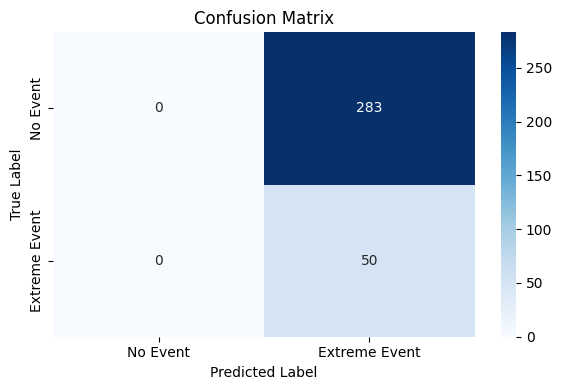

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, roc_auc_score, balanced_accuracy_score, 
                           precision_score, recall_score, confusion_matrix, f1_score)

# Make predictions
y_pred = final_model.predict(X_test.values)
y_true = y_test.values.astype(int)

# Calculate metrics
metrics = {
    'F2 Score': fbeta_score(y_true, y_pred, beta=2),
    'F1 Score': fbeta_score(y_true, y_pred, beta=1),
    'Precision': precision_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'Accuracy': accuracy_score(y_true, y_pred),
    'AUC': roc_auc_score(y_true, y_pred),
    'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred)
}

# Print metrics in a organized way
print("Test Set Metrics:")
print("-" * 40)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Event', 'Extreme Event'],
            yticklabels=['No Event', 'Extreme Event'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


We see that the model is prediciting all the test samples as extreme events, because of the metric used for optimization. It has not learned how to truly distinguish the two classes, hence we are severely underfitting the training data.

# Temporal CNN Model


Let's prepare the data for the temporal CNN model. Firstly, we will reload the data and then standardize the features, since we will be using a neural network. The daily returns do not need to be standardized due to their scale.

In [1]:
import numpy as np
import random
import torch

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [2]:
from src.data_preprocessing import StockDataPreprocessor

stock_prices = StockDataPreprocessor(
        ticker="AAPL", start_date="2020-01-01", end_date="2024-01-01"
    ).download_and_prepare_stock_data()
# Standardize the features
stock_prices = StockDataPreprocessor.standardize_data(stock_prices, ['Open', 'High', 'Low', 'Close', 'Volume'])
stock_prices.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,,
2015-01-05 00:00:00+00:00,23.687305,-1.031309,-1.025440,-1.030020,-1.022063,1.965753,-2.817151,0.0
2015-01-06 00:00:00+00:00,23.689533,-1.031264,-1.030777,-1.033506,-1.029804,2.054466,0.009405,0.0
2015-01-07 00:00:00+00:00,24.021717,-1.024681,-1.027408,-1.024256,-1.026884,0.546695,1.402239,1.0
2015-01-08 00:00:00+00:00,24.944683,-1.006389,-1.010130,-1.015318,-1.017906,1.676948,3.842215,0.0
2015-01-09 00:00:00+00:00,24.971437,-1.005859,-1.005318,-1.008570,-1.002691,1.344479,0.107255,1.0


We continue by splitting the data into training, validation and test sets.

In [3]:
# Split data into train, validation and test sets
X_train, y_train, X_val, y_val, X_test, y_test = StockDataPreprocessor.split_data(
    stock_prices,
    ["Open", "High", "Low", "Close", "Volume", "Daily_Returns"],
    "Extreme_Event",
    train_ratio=0.7,
    val_ratio=0.85,
)

Training features shape: (1597, 6), labels shape: (1597,)
Validation features shape: (342, 6), labels shape: (342,)
Test features shape: (343, 6), labels shape: (343,)


Finally, to predict whether an extreme event will occur tomorrow, given the past 10 days, we ought to transform the data into sequences with shape `[n_samples, n_features, lookback]`, where $lookback = 10$.

In [4]:
X_train, y_train = StockDataPreprocessor.create_sequences(X_train, y_train, lookback=10)
X_val, y_val = StockDataPreprocessor.create_sequences(X_val, y_val, lookback=10)
X_test, y_test = StockDataPreprocessor.create_sequences(X_test, y_test, lookback=10)

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")

Training features shape: (1587, 6, 10), labels shape: (1587,)
Validation features shape: (332, 6, 10), labels shape: (332,)
Test features shape: (333, 6, 10), labels shape: (333,)


For the defintion of the temporal CNN model and the management of the training process, we will use the `lightning` library. All the relevant code is implemented in the `src/temporal_cnn.py` file. We import the necessary functions and classes, we train the model and plot the training and validation losses.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/nikolaosmourdoukoutas/ai2c_assignment/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/nikolaosmourdoukoutas/ai2c_assignment/checkpoints exists and is not empty.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | cnn  | Sequential | 124 K  | train
--------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.498     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


/Users/nikolaosmourdoukoutas/ai2c_assignment/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/nikolaosmourdoukoutas/ai2c_assignment/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/nikolaosmourdoukoutas/ai2c_assignment/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 14: 100%|██████████| 25/25 [00:00<00:00, 55.58it/s, v_num=16, train_loss=0.495, val_loss=0.590]


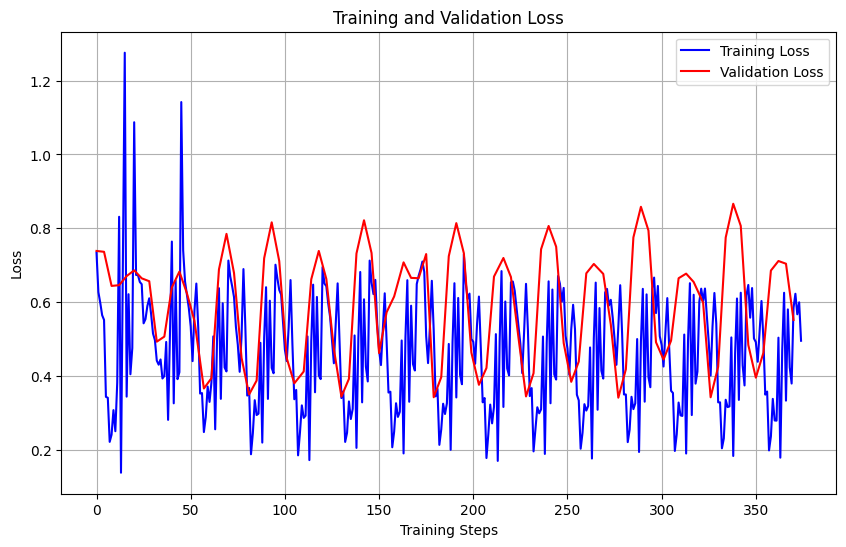

In [142]:
from src.temporal_cnn import ExtremeEventNNPredictor

tcnn_model = ExtremeEventNNPredictor(X_train.shape[1], 
                                X_train.shape[2],
                                conv_channels=64,
                                kernel_size=3,
                                hidden_dim=128,
                                dropout_prob=0.3,
                                learning_rate=1e-3)

checkpoint_callback = tcnn_model.train(
        X_train, y_train, X_val, y_val, batch_size=64, max_epochs=100, patience=10
    )
tcnn_model.plot_training_history()


We see that the model if far from converged. Let's evaluate it on the test set.

In [134]:
from src.temporal_cnn import TCNN

best_model = TCNN.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    n_features=X_train.shape[1],
    lookback=X_train.shape[2],
    learning_rate=1e-3,
    hidden_dim=128,
    conv_channels=64,
    kernel_size=3,
    dropout_prob=0.4,
)


F2 Score            : 0.1322
F1 Score            : 0.1558
Precision           : 0.2222
Recall              : 0.1200
Accuracy            : 0.8048
AUC                 : 0.5229
Balanced Accuracy   : 0.5229
----------------------------------------


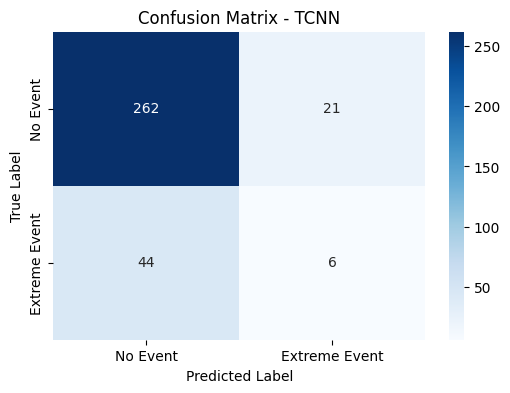

In [141]:
from src.model_evaluation import ModelEvaluator

evaluator = ModelEvaluator(model=best_model, model_type="TCNN")
metrics = evaluator.evaluate(X_test, y_test)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

evaluator.plot_confusion_matrix(X_test, y_test)

The TCNN is definetely better than the random forest model, since it is able to accurately predict 6 extreme events and seems to slighly have learned how to distinguish between the two classes. Nevertheless, the overall performance is still quite poor.

# Improvements

## Adding more features

Since we are intrested in predicting extreme events, we will include three additional features that could provide useful information for the task at hand. Specifically, we will include:

-  10-day Rolling Volatility: Periods of high volatility often cluster together, and extreme events are more likely during volatile periods. 
-  Volume Relative to 10-day Moving Average: Unusual trading volume often precedes or accompanies extreme price movements.
- VIX Index: Market-wide volatility often correlates with individual stock extreme movements.

The 10-day window was chosen, since we will be predicting if an extreme event occurs tomorrow based on the past 10 days of data.

In [4]:
from src.data_preprocessing import StockDataPreprocessor
# Insantiate the preprocessor and download the data
preprocessor = StockDataPreprocessor(ticker="AAPL", start_date="2015-01-01", end_date="2024-01-31")
stock_prices = preprocessor.download_and_prepare_stock_data()
# Add 10-day rolling volatility, volume relative to 10-day moving average and VIX index
stock_prices = preprocessor.add_features()
stock_prices.head()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event,rolling_volatility,relative_volume,VIX
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,,
2015-01-20 00:00:00+00:00,24.237967,27.180000,27.242500,26.625000,26.959999,199599600,2.575719,0.0,0.020475,0.870711,19.889999
2015-01-21 00:00:00+00:00,24.423004,27.387501,27.764999,27.067499,27.237499,194303600,0.763421,1.0,0.020516,0.873868,18.850000
2015-01-22 00:00:00+00:00,25.058376,28.100000,28.117500,27.430000,27.565001,215185600,2.601532,0.0,0.021541,0.944521,16.400000
2015-01-23 00:00:00+00:00,25.187693,28.245001,28.437500,27.882500,28.075001,185859200,0.516060,0.0,0.017986,0.834702,16.660000
2015-01-26 00:00:00+00:00,25.214437,28.275000,28.590000,28.200001,28.434999,222460000,0.106182,1.0,0.017986,0.995652,15.520000


In [6]:
stock_prices = StockDataPreprocessor.standardize_data(stock_prices, ['Open', 'High', 'Low', 'Close', 'Volume', 'rolling_volatility', 'relative_volume', 'VIX'])
stock_prices.head()

Price,Adj Close,Close,High,Low,Open,Volume,Daily_Returns,Extreme_Event,rolling_volatility,relative_volume,VIX
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,,
2015-01-20 00:00:00+00:00,24.237967,-1.024994,-1.028615,-1.029752,-1.028619,1.133914,2.575719,0.0,0.488964,-0.435340,0.182400
2015-01-21 00:00:00+00:00,24.423004,-1.021326,-1.019472,-1.021842,-1.023709,1.055852,0.763421,1.0,0.493563,-0.424914,0.044399
2015-01-22 00:00:00+00:00,25.058376,-1.008732,-1.013303,-1.015361,-1.017915,1.363647,2.601532,0.0,0.609060,-0.191551,-0.280699
2015-01-23 00:00:00+00:00,25.187693,-1.006170,-1.007704,-1.007272,-1.008891,0.931384,0.516060,0.0,0.208492,-0.554276,-0.246199
2015-01-26 00:00:00+00:00,25.214437,-1.005639,-1.005035,-1.001595,-1.002522,1.470870,0.106182,1.0,0.208492,-0.022667,-0.397469


In [7]:
# Split data into train, validation and test sets
X_train, y_train, X_val, y_val, X_test, y_test = StockDataPreprocessor.split_data(
    stock_prices,
    ["Open", "High", "Low", "Close", "Volume", "rolling_volatility", "relative_volume", "VIX", "Daily_Returns"],
    "Extreme_Event",
    train_ratio=0.7,
    val_ratio=0.85,
)

# Create sequences
X_train, y_train = StockDataPreprocessor.create_sequences(X_train, y_train, lookback=10)
X_val, y_val = StockDataPreprocessor.create_sequences(X_val, y_val, lookback=10)
X_test, y_test = StockDataPreprocessor.create_sequences(X_test, y_test, lookback=10)

Training features shape: (1590, 9), labels shape: (1590,)
Validation features shape: (341, 9), labels shape: (341,)
Test features shape: (341, 9), labels shape: (341,)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/nikolaosmourdoukoutas/ai2c_assignment/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/nikolaosmourdoukoutas/ai2c_assignment/checkpoints exists and is not empty.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | cnn  | Sequential | 860 K  | train
--------------------------------------------
860 K     Trainable params
0         Non-trainable params
860 K     Total params
3.444     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/nikolaosmourdoukoutas/ai2c_assignment/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/nikolaosmourdoukoutas/ai2c_assignment/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/nikolaosmourdoukoutas/ai2c_assignment/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 25/25 [00:00<00:00, 57.23it/s, v_num=7, train_loss=0.479, val_loss=0.548]


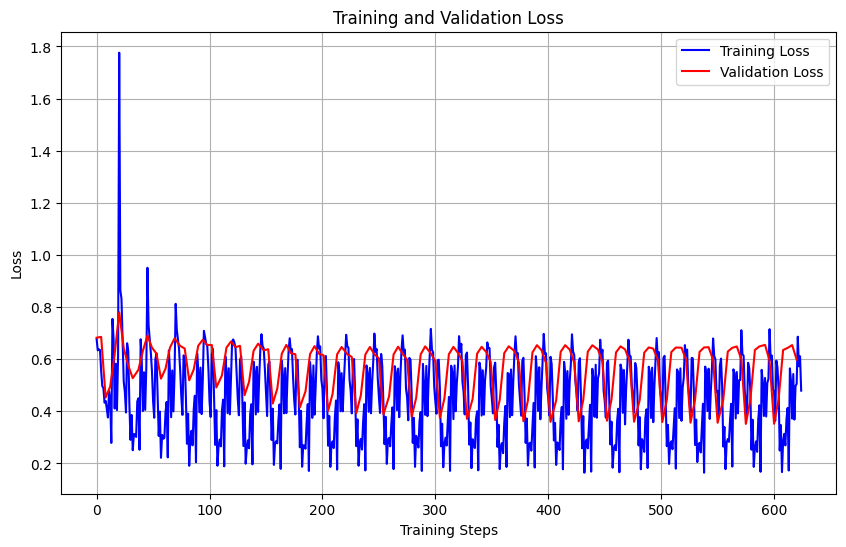

In [34]:
from src.temporal_cnn import ExtremeEventNNPredictor

tcnn_model = ExtremeEventNNPredictor(X_train.shape[1], 
                                X_train.shape[2],
                                conv_channels=200,
                                kernel_size=3,
                                hidden_dim=256,
                                dropout_prob=0.5,
                                learning_rate=1e-4)

checkpoint_callback = tcnn_model.train(
        X_train, y_train, X_val, y_val, batch_size=64, max_epochs=100, patience=10
    )
tcnn_model.plot_training_history()

In [35]:
from src.temporal_cnn import TCNN

best_model = TCNN.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    n_features=X_train.shape[1],
    lookback=X_train.shape[2],
    learning_rate=1e-3,
    hidden_dim=192,
    conv_channels=200,
    kernel_size=3,
    dropout_prob=0.4,
)


RuntimeError: Error(s) in loading state_dict for TCNN:
	size mismatch for cnn.7.weight: copying a param with shape torch.Size([256, 2400]) from checkpoint, the shape in current model is torch.Size([192, 2400]).
	size mismatch for cnn.7.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for cnn.10.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([1, 192]).

F2 Score            : 0.0000
F1 Score            : 0.0000
Precision           : 0.0000
Recall              : 0.0000
Accuracy            : 0.8399
AUC                 : 0.4912
Balanced Accuracy   : 0.4912
----------------------------------------


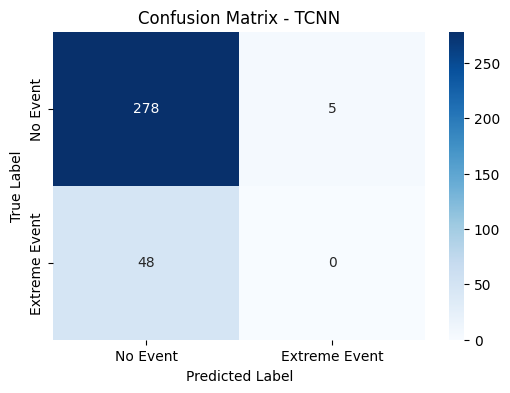

In [36]:
from src.model_evaluation import ModelEvaluator

evaluator = ModelEvaluator(model=best_model, model_type="TCNN")
metrics = evaluator.evaluate(X_test, y_test)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

evaluator.plot_confusion_matrix(X_test, y_test)